In [1]:
# INSTALLING THE LIBRARIES AND DEPENDENCIES:
import time
import numpy as np
import torch
from torch import nn 
from d2l import torch as d2l

In [2]:
# DEFINING FUNCTION TO ADD TO CLASS:
def add_to_class(Class):
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

*Note:*
* Let's implement a class *A* with a method *do*. Instead of having code for both *A* and *do* in the same code block, let's declare class *A* and create an instance *a*. 

In [3]:
# DEFINING THE CLASS:
class A:
    def __init__(self):
        self.b = 1
a = A() # Initializing an instance. 

In [4]:
# ADDING METHOD TO THE CLASS:
@add_to_class(A)
def do(self):
    print("Class attribute 'a' is", self.b)
a.do()

Class attribute 'a' is 1


*Note:*
* Let's define a utility class that saves all arguments in a class's __init__ method as a class attributes. 

In [5]:
# DEFINING THE CLASS:
class HyperParameters:
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented

In [6]:
# INITALIZING THE HYPERPARAMETERS:
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))
b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


*Note:*
* Let's implement the utility that allows us to plot experiment progres iteratively named as *ProgressBoard*. 

In [7]:
# DEFINING THE PROGRESSBOARD:
class ProgressBoard(d2l.HyperParameters):
    """Plot data points in animation"""
    def __init__(
        self, xlabel=None, ylabel=None, xlim=None, ylim=None,
        xscale='linear', yscale='linear', 
        ls=['-', '--', '-.', ':'], figsize=(4.5, 3.5), display=True):
        self.save_hyperparameters()
    
    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

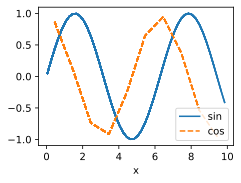

In [8]:
# IMPLEMENTATION OF PROGRESSBOARD:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

*Models & Modules:*
* The `Module` class contains three methods:
    - The `__init__` method stores the learnable parameters.
    - The `training_step` method accepts a data branch to return the loss value.
    - The `configure_optimizers` method returns the optimization method that is used to update the learnable parameters.
    - The `validation_step` method reports the evaluation measures.

In [10]:
# DEFINING MODULE CLASS:
class Module(nn.Module, d2l.HyperParameters):
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
    
    def loss(self, y_hat, y):
        raise NotImplementedError
    
    def forward(self, X):
        assert hasattr(self, 'net'), "Neural network is defined"
        return self.net(X)
    
    def plot(self, key, value, train):
        """Plot a point in animation"""
        assert hasattr(self, 'trainer'), "Trainer is not defined"
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(
            x, value.to(d2l.cpu()).detach().numpy(),
            ('train_' if train else 'val_') + key, every_n=int(n))
    
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l
    
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)
    
    def configure_optimizer(self):
        raise NotImplementedError


In [11]:
# SKELETON OF THE DATA MODULE:
class DataModule(d2l.HyperParameters):
    def __init__(self, root="../data", num_workers=4):
        self.save_hyperparameters()
    
    def get_dataloader(self, train):
        raise NotImplementedError
    
    def train_dataloader(self):
        return self.get_dataloader(train=True)
    
    def val_dataloader(self):
        return self.get_dataloader(val=False)

In [ ]:
# SKELETON OF THE TRAINER CLASS:
class Trainer(d2l.HyperParameters):
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_value=0):
        self.save_hyperparameters()
        assert num_gpus == 0, "No GPU support yet"
    
    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader) \
                                if self.val_dataloader is not None else 0)
    
    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model
    
    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0 
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    
    def fit_epoch(self):
        raise NotImplementedError 